# Global ensitivity Analysis
## Project initialisation

In [3]:
from brightway2 import *
from __future__ import unicode_literals, print_function

Using environment variable BRIGHTWAY2_DIR for data directory:
/home/jovyan/data


In [4]:
projects.set_current("Global Sensitivity Analysis demo")

Adding some uncertainties in sample data (from [this notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/Getting%20Started%20with%20Brightway2.ipynb))

In [5]:
bw2setup()

Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[#########                     ] | ETA: 00:00:00

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/10/2017 11:58:01
  Finished: 04/10/2017 11:58:02
  Total time elapsed: 00:00:00
  CPU %: 78.40
  Memory %: 0.99
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 1.12 seconds
Wrote 665 LCIA methods with 169551 characterization factors
Creating core data migrations



In [6]:
import zipfile
import os
from bw2data.utils import download_file

filepath = download_file("forwast.bw2package.zip", url="http://lca-net.com/wp-content/uploads/")
dirpath = os.path.dirname(filepath)
zipfile.ZipFile(filepath).extractall(dirpath)
BW2Package.import_file(os.path.join(dirpath, "forwast.bw2package"))

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


Title: Writing activities to SQLite3 database:
  Started: 04/10/2017 11:58:52
  Finished: 04/10/2017 11:58:57
  Total time elapsed: 00:00:04
  CPU %: 64.30
  Memory %: 1.94


[Brightway2 SQLiteBackend: forwast]

## Adding uncertainties

In [7]:
from bw2data.utils import uncertainify
from stats_arrays import NormalUncertainty
uncertain_db = Database("forwast uncertain +")
uncertain_db.write(
    uncertain_db.relabel_data(
        uncertainify(
            Database("forwast").load(), 
            NormalUncertainty
        ), 
        "forwast uncertain +" 
    )
)

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


Title: Writing activities to SQLite3 database:
  Started: 04/10/2017 11:58:58
  Finished: 04/10/2017 11:59:03
  Total time elapsed: 00:00:04
  CPU %: 66.00
  Memory %: 1.88


In [8]:
method_key=('ReCiPe Endpoint (I,A)', 'ecosystem quality', 'total')#'IMPACT 2002+ (Endpoint)', 'climate change', 'total')
activity = uncertain_db.search('Wood products EU27')[0]
lca = LCA({activity: 1}, method_key)

## Random initialization
Initialization of the RNG stuff in the same way that in the MonteCarloLCA class

In [10]:
lca.load_lci_data()
from stats_arrays.random import MCRandomNumberGenerator
tech_rng = MCRandomNumberGenerator(lca.tech_params)
bio_rng = MCRandomNumberGenerator(lca.bio_params)
lca.load_lcia_data()
cf_rng = MCRandomNumberGenerator(lca.cf_params)

## Local sensitivity analysis

In [9]:
from lsa import lsa
rsca_summary, rscb_summary = lsa(lca)

## Binding RSC results and uncertainties
The local sensitivity analysis give us the indices of matrices A and B that have the more relevant RSC (relative sensitivity coefficients). The purpose is now to fetch the associated uncertainties from the database.

In [157]:
import numpy as np
A_indices = np.array(np.array(rsca_summary)[:,1:3],int).tolist()
B_indices = np.array(np.array(rscb_summary)[:,1:3],int).tolist()

We will fetch these uncertainties in the attributes `tech_params` and `bio_params` of the LCA object.

In [158]:
from pandas import DataFrame
tech_df = DataFrame.from_records(lca.tech_params)
bio_df = DataFrame.from_records(lca.bio_params)

Look for example at the uncertainties of the first sensible element for the matrix A

In [159]:
tech_df[(tech_df.row==A_indices[0][0]) & (tech_df.col==A_indices[0][1])]

,input,output,row,col,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
138,4434,4434,138,138,0,0,1.00000,1.00000,NaN,NaN,NaN,NaN,False
17927,4434,4434,138,138,1,3,0.41977,0.41977,0.041977,NaN,0.377793,0.461747,False


We can see that we get more than one element, because we should consider the column `type` which is defined in the [utils.py module](https://bitbucket.org/cmutel/brightway2-calc/src/105e24e2d803c96773651ed73c43d850f9c23548/bw2calc/utils.py?at=default&fileviewer=file-view-default#utils.py-144) as follow:
```
    TYPE_DICTIONARY = {
        "unknown": -1,
        "production": 0,
        "technosphere": 1,
        "biosphere": 2,
        "substitution": 3,
    }
```
This ```field``` attribute is setted during the matices building process in the class ```TechnosphereBiosphereMatrixBuilder``` of the [module matrices.py](https://bitbucket.org/cmutel/brightway2-calc/src/105e24e2d803c96773651ed73c43d850f9c23548/bw2calc/matrices.py?at=default&fileviewer=file-view-default#matrices.py-176).

So, we can restrict to the row with the concerned type, and we get the ```minimum``` and ```maximum``` values:

In [160]:
tech_df[(tech_df.type==1) & (tech_df.row==A_indices[0][0]) & (tech_df.col==A_indices[0][1])]

,input,output,row,col,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
17927,4434,4434,138,138,1,3,0.41977,0.41977,0.041977,NaN,0.377793,0.461747,False


![fixme](https://www.dokuwiki.org/lib/images/smileys/fixme.gif)
But for some element, we can't find minimum and maximum values!

In [161]:
print(A_indices[6])
tech_df[(tech_df.row==A_indices[6][0]) & (abs(tech_df.col-A_indices[6][1])<4)]

[108, 108]


,input,output,row,col,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
108,4404,4404,108,108,0,0,1.0,1.0,NaN,NaN,NaN,NaN,False


In [162]:
errors_A = [a for a in A_indices if len(tech_df[(tech_df.type==1) & (tech_df.row==a[0]) & (tech_df.col==a[1])])==0]
errors_B = [b for b in B_indices if len(bio_df[(bio_df.type==2) & (bio_df.row==b[0]) & (bio_df.col==b[1])])==0]
print("Errors for A: {}/{} {}".format(len(errors_A), len(A_indices), errors_A))
print("Errors for B: {}/{} {}".format(len(errors_B), len(B_indices), errors_B))

Errors for A: 3/40 [[108, 108], [49, 49], [254, 254]]
Errors for B: 0/18 []


![fixme](https://www.dokuwiki.org/lib/images/smileys/fixme.gif)
Dirty solution for patching the datasets:

In [163]:
A_indices = [a for a in A_indices if len(tech_df[(tech_df.type==1) & (tech_df.row==a[0]) & (tech_df.col==a[1])])>0]
B_indices = [b for b in B_indices if len(bio_df[(bio_df.type==2) & (bio_df.row==b[0]) & (bio_df.col==b[1])])>0]

## Defining the problem data
Here, we want to define the parameters to sample using a list of selected elements of the biosphere and technosphere matrices

In [164]:
import numpy as np
#A_indices = np.array(np.array(rsca_summary)[:6,1:3],int).tolist()
#B_indices = np.array(np.array(rscb_summary)[:6,1:3],int).tolist()
rev_activity, rev_product, rev_bio = lca.reverse_dict()
morris_problem = {
    'num_vars':len(A_indices)+len(B_indices),
    'names':[],
    'bounds':[],
    'groups':None
}
morris_problem['names'] += [
    'Technosphere '+ str(Database(rev_activity[x[0]][0]).get(rev_activity[x[0]][1])) + ' x ' + str(Database(rev_product[x[1]][0]).get(rev_product[x[1]][1]))
    for x in A_indices
    ]
morris_problem['names'] += [
    'Biosphere '+str(Database(rev_bio[x[0]][0]).get(rev_bio[x[0]][1])) + ' x ' + str(Database(rev_activity[x[1]][0]).get(rev_activity[x[1]][1]))
    for x in B_indices
    ]
# retrieve min and max values for populating morris_problem['bounds']
from pandas import DataFrame
tech_df = DataFrame.from_records(lca.tech_params)
bio_df = DataFrame.from_records(lca.bio_params)
morris_problem['bounds'] = [tech_df[(tech_df.type==1) & (tech_df.row==a_ij[0]) & (tech_df.col==a_ij[1])][['minimum','maximum']].values[0] for a_ij in A_indices] + [bio_df[(bio_df.type==2) & (bio_df.row==b_ij[0]) & (bio_df.col==b_ij[1])][['minimum','maximum']].values[0] for b_ij in B_indices]

## Computing Sobol indices

### Multiprocessing class
This class will generate the Morris sample and perform lcia computations using multiprocessing feature.

In [249]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
import multiprocessing
import pyprind
import math

class ParallelGSALCA:
    def __init__(self, demand, method, morris_problem):
        self.demand = demand
        self.method = method
        # TODO generate morris_problem instead of parameter
        self.morris_problem = morris_problem
    def single_worker(self, sample):
        '''
        Computes the lcia impacts for the given data sampling corresponding to the initial morris problem.
        Returns an array containing the aggregated score and then the impacts for each category.
        '''
        lca = LCA(self.demand, self.method)
        lca.load_lci_data()
        if lca.lcia:
            lca.load_lcia_data()
        if lca.weighting:
            lca.load_weighting_data            
        for a_ij, value in zip(self.A_indices, sample[:len(self.A_indices)]):
            #print('aij',tuple(a_ij),value, lca.technosphere_matrix[tuple(a_ij)])
            lca.technosphere_matrix[tuple(a_ij)] = value
            #print(lca.technosphere_matrix[tuple(a_ij)])
        for b_ij, value in zip(self.B_indices, sample[len(self.A_indices):]):
            #print('bij',tuple(b_ij),value)
            lca.biosphere_matrix[tuple(b_ij)] = value
        if not hasattr(lca, "demand_array"):
            lca.build_demand_array()
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            lca.lci_calculation()
        if lca.lcia:
            lca.lcia_calculation()
        return np.concatenate(([lca.score], np.array(lca.characterized_inventory.sum(axis=1).ravel())[0]))
    def gsa(self, A_indices, B_indices, number_of_trajectories, progressBar=True, cpus=None, chunk_size=None):
        '''
        Samples the A and B element using Morris method and return the computed impact
        for the aggregated score and then for each category of impact.
        '''
        self.A_indices = A_indices
        self.B_indices = B_indices
        cpus = cpus or multiprocessing.cpu_count()
        # TODO propose an automatic number_of_trajectories
        self.samples = ms.sample(self.morris_problem, number_of_trajectories, num_levels=4, grid_jump=2)
        if chunk_size:
            self.chunk_size = chunk_size
        else:
            self.chunk_size = max(cpus, number_of_trajectories // 100)
        pool = multiprocessing.Pool(processes=cpus)
        if progressBar:
            bar = pyprind.ProgBar(max(1,math.ceil(len(self.samples)/self.chunk_size)))
        chunks = []
        scores = [[] for i in range(1 + lca.characterization_matrix.shape[0])]
        # store in 'stores' all the mid-point impact
        for sample in self.samples:
            chunks.append(sample)
            if len(chunks) == self.chunk_size:
                for i,result_by_impact in enumerate(map(list,zip(*pool.map(self.single_worker, chunks)))):
                    scores[i] += result_by_impact
                if progressBar:
                    bar.update()
                chunks=[]
        if len(chunks):
            for i,result_by_impact in enumerate(map(list,zip(*pool.map(self.single_worker, chunks)))):
                scores[i] += result_by_impact
            if progressBar:
                bar.update()
            chunks=[]
        self.scores = scores
        return scores
    def gsa_analyse(self):
        return [ma.analyze(self.morris_problem, self.samples, np.array(score), num_levels=4, grid_jump=2) for score in self.scores]
    

### Go

In [250]:
gsalca = ParallelGSALCA({activity: 1}, method_key, morris_problem)
scores = gsalca.gsa(A_indices, B_indices, number_of_trajectories = 10)#, progressBar=False)

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:13


## Analysis
Now, we can inspect the Sobol indices with the ```analyse``` method, for each category of impact.

In [294]:
analyse = gsalca.gsa_analyse()
print(analyse[0].keys())

dict_keys(['mu_star_conf', 'names', 'sigma', 'mu', 'mu_star'])


First, looking at sensitivity for the aggregated score (first element)

In [254]:
si_score=DataFrame(analyse[0])
si_score[si_score['mu']!=0]

,mu,mu_star,mu_star_conf,names,sigma
5,6.513754e-02,6.513754e-02,8.426966e-03,"Technosphere '_32 Wood products, except furnit...",1.421993e-02
6,-9.335340e-04,9.335340e-04,5.760796e-05,"Technosphere '113 Waste treatment, Composting ...",9.955194e-05
7,4.473833e-03,4.473833e-03,4.206133e-04,"Technosphere '129 Waste treatment, Land applic...",7.141321e-04
11,1.133506e-01,1.133506e-01,2.932518e-02,"Technosphere '_39 Fertiliser, N, EU27' (kilogr...",4.910882e-02
13,-2.016718e-03,2.016718e-03,5.814751e-04,"Technosphere '_39 Fertiliser, N, EU27' (kilogr...",9.630698e-04
15,1.187698e-01,1.187698e-01,6.554203e-02,"Technosphere '_43 Chemicals n.e.c., EU27' (kil...",1.165667e-01
16,7.910077e-02,7.910077e-02,1.339684e-02,Technosphere '_85 Land transport and transport...,2.340514e-02
20,6.198074e-03,6.198074e-03,5.772469e-04,"Technosphere '113 Waste treatment, Composting ...",9.951440e-04
24,-2.394287e-02,2.394287e-02,4.067541e-03,"Technosphere '_75 Electricity, steam and hot w...",6.904569e-03
25,-2.236436e-02,2.236436e-02,1.996112e-03,"Technosphere '_10 Coal, lignite, peat, EU27' (...",3.388296e-03


Sensitivities for a category of impact

In [198]:
df=DataFrame(analyse[1])
df[df['mu']!=0]

,mu,mu_star,mu_star_conf,names,sigma
5,1.587896e-02,1.587896e-02,4.194879e-03,"Technosphere '_32 Wood products, except furnit...",7.160962e-03
6,-9.804106e-04,9.804106e-04,7.800823e-05,"Technosphere '113 Waste treatment, Composting ...",1.294838e-04
7,5.043827e-03,5.043827e-03,6.357672e-04,"Technosphere '129 Waste treatment, Land applic...",1.032176e-03
11,4.484855e-02,4.484855e-02,1.306621e-02,"Technosphere '_39 Fertiliser, N, EU27' (kilogr...",2.151610e-02
13,-9.101598e-04,9.101598e-04,1.358196e-04,"Technosphere '_39 Fertiliser, N, EU27' (kilogr...",2.350379e-04
15,7.228372e-02,7.228372e-02,3.932023e-02,"Technosphere '_43 Chemicals n.e.c., EU27' (kil...",6.746696e-02
16,4.142660e-02,4.142660e-02,7.934035e-03,Technosphere '_85 Land transport and transport...,1.388275e-02
20,6.044877e-03,6.044877e-03,5.847317e-04,"Technosphere '113 Waste treatment, Composting ...",1.023958e-03
24,-3.596837e-02,3.596837e-02,4.234259e-03,"Technosphere '_75 Electricity, steam and hot w...",7.197639e-03
25,-3.189817e-02,3.189817e-02,5.551843e-03,"Technosphere '_10 Coal, lignite, peat, EU27' (...",9.455583e-03


### Comparing sensitivities on single score and categories
We select the sensitivity indexes with highest ```mu``` values for single score, and we will look at the SI computed for each category.

In [263]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

We drop the category that have a sum of ```mu``` indices to zero

In [301]:
interesting_analyse = list(filter(lambda x:sum(abs(x['mu']))>0,analyse[1:]))

Now, we plot the ```mu``` indices for each keeped category, and highlighting in red the indices of the process that gives the highest sensitivities on single score.

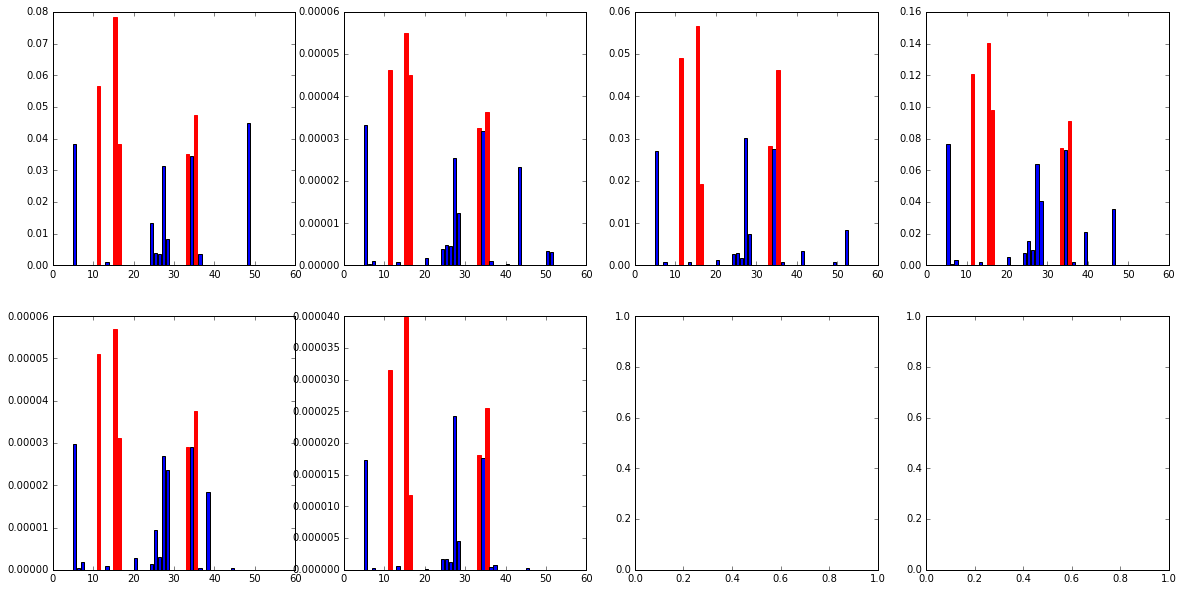

In [300]:
hsi_score_index = si_score.mu.abs().sort_values().index[-5:]
hsi_score = si_score.reindex(hsi_score_index)
fig, axes = plt.subplots(math.ceil((len(interesting_analyse))/4),4)
for ax, si in zip(axes.flat, interesting_analyse):
    rects = ax.bar(range(len(si['mu'])),abs(si['mu']))
    for i,patch in enumerate(rects.patches):
        if i in hsi_score_index:
            patch.set_color('red')